In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install tensorflowjs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 75.9 MB/s eta 0:00:00


In [8]:
import csv
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from data import BodyPart
import tensorflow as tf
import tensorflowjs as tfjs

In [9]:
tfjs_model_dir = 'model'

In [10]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(['filename'],axis=1, inplace=True)
    classes = df.pop('class_name').unique()
    y = df.pop('class_no')

    X = df.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes

In [11]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center

In [12]:
def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

    It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)
    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)
    return pose_size


In [13]:
def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size
    return landmarks

In [14]:
def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)
    return embedding

In [15]:
def preprocess_data(X_train):
    processed_X_train = []
    for i in range(X_train.shape[0]):
        embedding = landmarks_to_embedding(tf.reshape(tf.convert_to_tensor(X_train.iloc[i]), (1, 51)))
        processed_X_train.append(tf.reshape(embedding, (34)))
    return tf.convert_to_tensor(processed_X_train)

In [16]:
X, y, class_names = load_csv('train_data.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
X_test, y_test, _ = load_csv('test_data.csv')

In [17]:
processed_X_train = preprocess_data(X_train)
processed_X_val =  preprocess_data(X_val)
processed_X_test = preprocess_data(X_test)

In [18]:
inputs = tf.keras.Input(shape=(34))
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

In [19]:
model = keras.Model(inputs, outputs)

In [20]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

In [22]:
# Start training
print('--------------TRAINING----------------')
history = model.fit(processed_X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


--------------TRAINING----------------
Epoch 1/200
74/81 [==========================>...] - ETA: 0s - loss: 1.6505 - accuracy: 0.4096
Epoch 1: val_accuracy improved from -inf to 0.62555, saving model to weights.best.hdf5
81/81 [==============================] - 3s 7ms/step - loss: 1.6152 - accuracy: 0.4233 - val_loss: 1.2518 - val_accuracy: 0.6256
Epoch 2/200
22/81 [=======>......................] - ETA: 0s - loss: 1.1846 - accuracy: 0.4972

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


73/81 [==========================>...] - ETA: 0s - loss: 1.1297 - accuracy: 0.5531
Epoch 2: val_accuracy improved from 0.62555 to 0.76211, saving model to weights.best.hdf5
81/81 [==============================] - 1s 7ms/step - loss: 1.1137 - accuracy: 0.5564 - val_loss: 0.9362 - val_accuracy: 0.7621
Epoch 3/200
73/81 [==========================>...] - ETA: 0s - loss: 0.8926 - accuracy: 0.6704
Epoch 3: val_accuracy improved from 0.76211 to 0.77974, saving model to weights.best.hdf5
81/81 [==============================] - 1s 6ms/step - loss: 0.8791 - accuracy: 0.6747 - val_loss: 0.7434 - val_accuracy: 0.7797
Epoch 4/200
79/81 [============================>.] - ETA: 0s - loss: 0.7766 - accuracy: 0.7215
Epoch 4: val_accuracy improved from 0.77974 to 0.85903, saving model to weights.best.hdf5
81/81 [==============================] - 1s 7ms/step - loss: 0.7741 - accuracy: 0.7230 - val_loss: 0.6203 - val_accuracy: 0.8590
Epoch 5/200
73/81 [==========================>...] - ETA: 0s - loss: 0

In [40]:
print('-----------------EVAUATION----------------')
loss, accuracy = model.evaluate(processed_X_test, y_test)
print('LOSS: ', loss*100)
print("ACCURACY: ", accuracy*100)

-----------------EVAUATION----------------
28/28 [==============================] - 0s 4ms/step - loss: 0.0239 - accuracy: 0.9920
LOSS:  2.390117570757866
ACCURACY:  99.20182228088379


<ipython-input-42-91d66dc800f2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


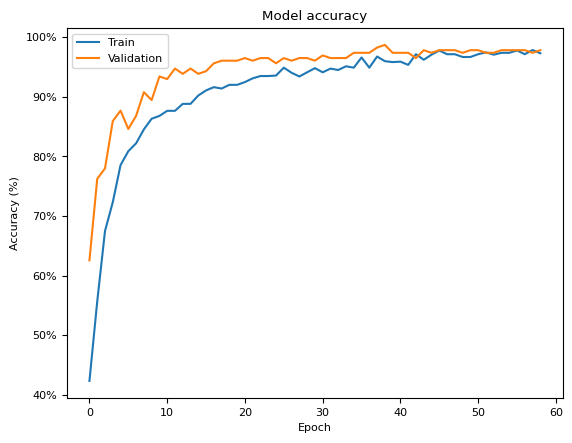

<ipython-input-42-91d66dc800f2>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


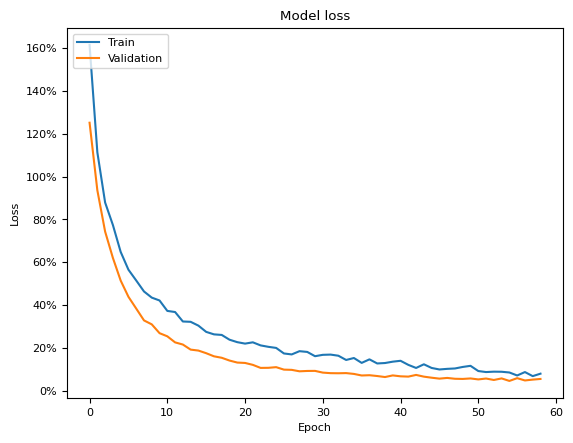

In [42]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy (%)')  # Adjusted ylabel
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Multiply y-axis ticks by 100
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Multiply y-axis ticks by 100
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

plt.show()


28/28 [==============================] - 0s 3ms/step


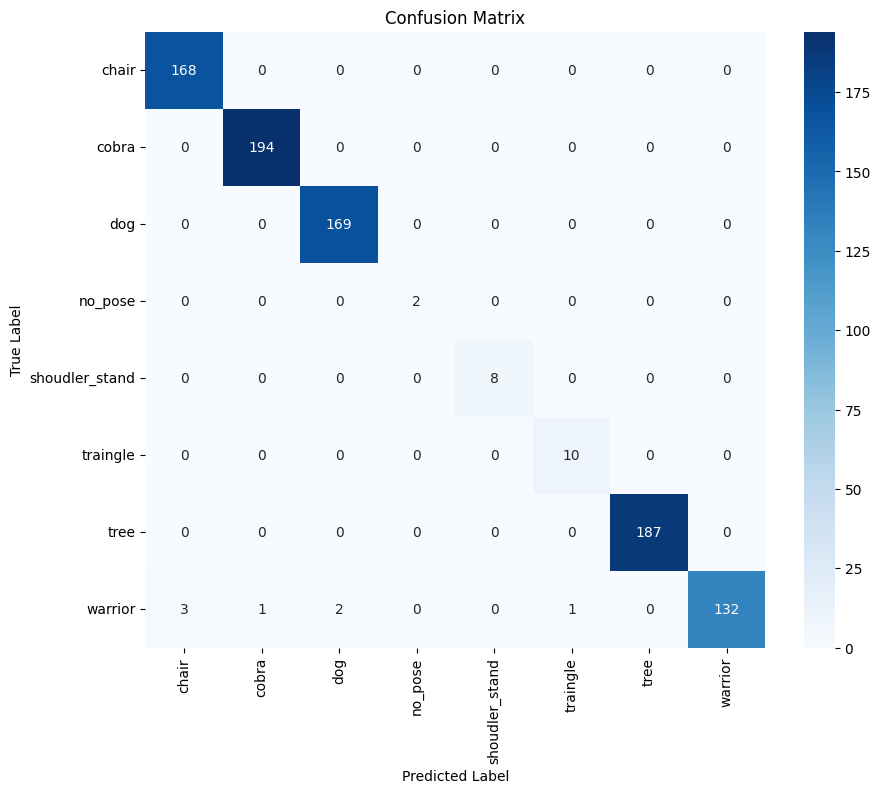

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


# Predict classes for test set
y_pred = model.predict(processed_X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [39]:
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print('tfjs model saved at ',tfjs_model_dir)

tfjs model saved at  model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
